# 5th Project - Image Classification - CIFAR-10

<img src="https://www.researchgate.net/profile/Wangmeng_Zuo/publication/281082007/figure/fig3/AS:669166587625483@1536553155733/Retrieval-results-top-10-returned-images-for-ten-CIFAR-10-test-images-using-Hamming.png" width="900px"/>


### Author: Arthur Dimitri Brito Oliveira <br>
arthur.dimitri@ee.ufcg.edu.br

# Introduction

This work describes the process of designing a Convolutional Neural Network for multiclass classification. Some theoretical fundaments are presented and the steps that led to the final model are detailed. Notice that due to time limitation in respect to the Kaggle GPU, we are just showing pictures of the loss and accuracy curves. The final model is loaded from disk. 

# Dataset Description

"*The CIFAR-10 dataset (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research.[1][2] The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes.[3] The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class.*" (Wikipedia)

# Objectives 

We aim to load this dataset, apply one-hot-encoding to the labels and normalize the image pixels before we dive into the machine learning pipeline. At the end of this project, we want a model that can predict satisfactorily the inputs, with a relatively low error. Besides it, we want a model that manages addressing the overfitting-underfitting trade-off.

## Dependencies

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/final-model/model.h5
/kaggle/input/figures/2d_convolution_pa3.png
/kaggle/input/finalnet/final_net.json
/kaggle/input/finalnet/final_net.h5


In [2]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras import regularizers
from keras.optimizers import RMSprop, Adadelta, Adam, Adamax, Nadam
from keras.callbacks import Callback
from keras import backend as K
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np
from keras.utils import np_utils

Using TensorFlow backend.


# Loading Data

In [3]:
(X_train, y_train),(X_validation, y_validation) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


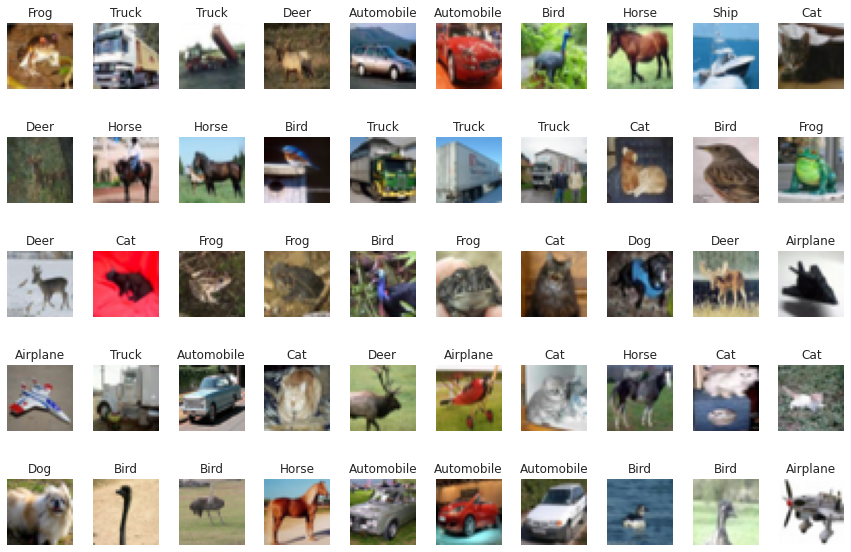

In [4]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.figure(figsize=(15,10))
sns.set_style('white')
for i in range(50):  
    plt.subplot(5, 10, i+1)
    plt.imshow(X_train[i].reshape((32, 32, 3)),cmap=plt.cm.hsv)
    plt.title(labels[y_train.reshape(1,len(y_train))[0][i]])
    plt.axis('off')
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

# Preprocessing

### Feature Scaling

The main objective with this preprocessing technique is to keep the pixels in a controlled range (0 to 1), making the distribution look like a gaussian centered at zero. Normalizing causes a faster convergence of the model. 

In [5]:
X_train = X_train.astype('float32')
X_validation = X_validation.astype('float32')
std_x_valid = np.std(X_validation)
mean_x_train = np.mean(X_train)
mean_x_valid = np.mean(X_validation)
X_train = X_train/mean_x_train
X_validation = X_validation/mean_x_valid
y_temp = y_validation

Here we apply categorical transformation to the class labels

In [6]:
y_train = np_utils.to_categorical(y_train.transpose()).reshape(50000,10)
y_validation = np_utils.to_categorical(y_validation.transpose()).reshape(10000,10)
input_shape = (32,32,3)

# Neural Network Architecture

### Theoretical Fundaments

### Activation Functions

There is a representation of a neuron with its inputs:


<img src="https://www.researchgate.net/profile/Juha_Jaaksi/publication/331607575/figure/fig3/AS:734257966231555@1552072149599/Main-elements-of-Artificial-Neuron-31-The-synaptic-weights-W1-W2-W3-Wn-are.jpg" width="900px"/>


The summing junction is given by the product of the input by a wheight, which indicates the influence of the given input to the output. 

### $$ z = w_1x_1 + w_2x_2 + ... + w_nx_n $$

Then the output of the neuron, taking into consideration a certain level of activity (treshold) is:

### $$ y = g(z) = g(w_1x_1 + w_2x_2 + ... + w_nx_n) $$

So the summing junction, a linear combination of the inputs, is transformed in a non-linear output. This is very useful since it adds non-linear properties to the inputs. 

#### Relu

<img src="https://www.learnopencv.com/wp-content/uploads/2017/10/relu-activation-function-1.png" width="900px"/>


For the negative input values, the result is zero, that means the neuron does not get activated. It is very popular in convolutional networks because it is proved to cause a faster convergence of the model and it prevents the vanishing gradients problem in the context of backpropagation. 

#### Softmax 

When we want to describe a probability distribution over a discrete variable consisting of n classes, the softmax function should be applied. It can be compared to the sigmoid function, but in this case it gives probabilities for multiple classes. For a layer L, the summing junction would be a product of the previous activation with the weights of the layer plus the biases associated with the layer L:

### $$ Z^{[L]} = w^{L}a^{[L-1]} + b^{L} $$


The activation on the softmax layer is:

## $$ a^{[L]} = \frac{e^{z^{[L]}}}{\sum_{j=1}^{n}t_i} $$  

So it gives a probability for each class taking into consideration all the class elements. 

<img src="https://www.researchgate.net/profile/Baptiste_Feron/publication/330479627/figure/fig1/AS:716404957409282@1547815660725/Softmax-Regression-Network-the-output-of-a-neural-network-represents-the-probability-of.png" width="900px"/>

In [7]:
y_train = y_train 

### **Convolution Layers**

A convolution is a mathematical operation that slides one function over another and measures the integral, or the area behind the curve, of
their pointwise multiplication. In the case of images, the function being slided is called a filter or kernel. Neurons in the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected
only to neurons located within a small rectangle in the first layer. 

## $$y[n] = \sum_{n=-\infty}^{\infty} x[ k ]h[ n - k ]$$

<img src="https://peltarion.com/static/2d_convolution_pa3.png" width="900px"/>

As a simple explanation, what a convolution layer does is extract features, depending on the filter applied, and convert it into a lower dimension, mantaining the main features of the original input. Each filter applied to the input will generate what is called as feature map that gives a representation of the input in respect to one aspect. This principle is show above after the first convolutional layer:

<img src="https://wiki.tum.de/download/attachments/23572254/Bildschirmfoto%202017-01-04%20um%2014.56.58.png?version=1&modificationDate=1485355682090&api=v2" width="900px"/>

What controls the filter sliding and hence the output representation of the image is a parameter called stride. If it is 1, for a 2x2 kernel there will be always an overlap. If we want to keep the same size after the convolution layer, we should apply a zero padding at the edges of the image.

### Pooling Layers

Maximum pooling, or max pooling, calculates the maximum value in each window sliding over a feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch. It gives even more sparse representation of the features in the image. 

<img src="https://www.novatec-gmbh.de/wp-content/uploads/conv_layer_schema-e1574164609481.gif" width="900px"/>

## Flatten Layer

Flattening means to reshape the previous matrix into one dimension. So a flatten layer in keras reshapes the tensor into a 1xN matrix, with N being the number of elements in that tensor. This is useful when we are reaching the end of the network before the fully connected layers. 

<img src="https://www.researchgate.net/profile/Budiman_Minasny/publication/334783857/figure/fig4/AS:786596169269249@1564550549811/Illustration-of-flatten-layer-that-is-connecting-the-pooling-layers-to-the-fully.png" width="900px"/>

## Dense Layer

Consists in a linear operation between the weights, in which all the inputs are connected to the ouput. The aim is to take the inputs from the feature analysis and apply weights to classify the initial input.
The last dense layer gets these operations and, by applying an activation function, gives the probabilities for each class.

## Regularization Layers

### Dropout Layers

How could we deal with overfitting with a simple approach? Dropout is the answer. It means that some neurons are stochastically dropped out of the network with a certain rate. The intuition behind it is that it can't rely on any feature, so it has to spread out the weights. With that the behavior of the network is expected to be more generalistic by extracting features that are more useful in general cases and not in a combination isolated example. 

<img src="https://miro.medium.com/max/1200/1*iWQzxhVlvadk6VAJjsgXgg.png" class="center" width="900px" >

The layers that have most of the parameters should be the ones that we are concerned about overfitting the model. At them we could adress a more agressive dropout rate. Normally, using a small dropout probability, from 20 to 50%, is recommended for the hyperparameter testing. A very low probability doesn't have a impactful effect on the model results.

Although applying the model makes the model slower to train, using a higher and controlled dropout gives the model an opportunity to acquire more independent representations of the data, making the ability of predicting unseen data more accurate.


# Training the Neural Network

## Regularization of Parameters

### Weight Decay

If our network is too complex/deeper, there is an overfitting trend. It means that our network fails to generalize satisfactorily. In order to prevent that, without taking out features, we can apply what is called weight decay. Let's that we have a cost function that we want to minimize:

### $$min_{w,b}J(w,b) ;  w \in R^{N_x}, b \in R$$

## $$J(w,b) = \sum_{i=1}^{N_x}L(\hat{y^{(i)}},y^{(i)}) + \frac{\lambda}{2m}||w||^2$$

To update the weights from backpropagation in the layer L, we also add a penalty:

## $$dw^{[L]} = (from back prop) + \frac{\lambda}{m}w^{L}$$

## $$w^{[L]} = w^{[L]} - \alpha dw^{[L]}$$

So that's why it is called weight decay. It forces the network to minimize the cost and make the weights have a lower influence on the final function, and thus making the decision boundaries more generic, and thus prevents overfitting. The difference between L1 and L2 regularizations is only how we sum the penalties. In L1 whe just sum de absolute values of the weights, whilst in L2 whe sum the square value of those weights. 

The way the penalties are applied make these two methods distinct in practice. L1 is robust dealing with outliers, while L2 have trouble with that. L1 gives a simples solution and more interpretable and can't deal with complex patterns, whilst L2 does the opposite. Combining these two techniques may give the model a good capacity of generalization. 

### Batch Normalization

To increase the stability of a neural network, batch normalization normalizes the output of a previous activation layer.It reduces overfitting because it has a slight regularization effects. The basic steps of the method are:

1. Compute the previous layer inputs operating with biases:

## $$ Z = XW $$

2. Subtract it from its mean:

## $$ Z' = Z -  \sum_{i=1}^{m}Z_i$$

3. Normalize the output of the layer:

## $$ \hat{Z} = \frac{Z'}{\sqrt{\epsilon + \frac{1}{m}\sum_{i=1}^{m}Z'^2}}$$

4. Multiply the normalized output by some arbitrary parameter and add some random parameter too:

## $$ a\hat{Z} + \beta $$


In practice what it does is make the cost function contour plot more simetric, making the path for the gradient descend based learning more uniform. 



# Metrics For Evaluating the Classifier

## Confusion Matrix

It shows visually how many labels were predicted correctly. From it, one can see how many classes have been misclassified and how good the model behaved for each one

<img src="https://gabrielelanaro.github.io/public/post_resources/multiclass/text4384.png" width="500px" height="500px"/> 


## Metrics - Precision, Recall and F1-score

First we need to define some terms:
1. True Positives - TP : correctly predicted classes. Example: A predicted as A
2. True Negatives - TN : correctly predicted element from its not original class. Example: A not predidcted as B
3. False Positives - FP : wrongly predicted element. A predicted as B
3. False Negatives - FN : when an element is not classified as its belonging class. A not predicted as A

### Precision 
Precision measures the amount of correctly predicted labels in respect to the total positive observations. It is about knowing how many elements predicted as a label really belong to it. 

## $$ Precision = \frac{TP}{TP+FP} $$


### Recall 
Recall measures the percentage of elements positively labeled in respect to all the observations in the actual class. The main objective is to know how much of the actual label we've correctly predicted.


##  $$ Recall = \frac{TP}{TP + FN} $$


### F1-score
F1 Score is the weighted average of Precision and Recall. It is useful to compare two models and a more powerful metric than simply accuracy. 

##  $$  F1 = 2\frac{Precision.Recall}{Precision + Recall}  $$

## Baseline Model

Since convolutional neural networks are a kind of feedfoward networks specialized in images, let's take some generic CNN design pattern as a guideline:
* Input -> Convolution -> Pooling -> Convolution -> Pooling -> Fully Conected Layer -> Output

Structuring this with Keras gives:

<img src="https://drive.google.com/uc?id=1-m7Eu8FQf5x3CRcj9rV-RlswS_oCZpLE" width="1600px" height="2000px"/> 


For instance, we have 32x32x3 input images and a first convolutional layer with 32 3x3 filters and stride 1, and 32 32x32 feature maps at the output of this layer, since we applied a zero-padding to keep the original input dimensions. We apply an activation function to these feature maps and keep convolving them with more and more filters applying pooling techniques to get more sparse representations and catch even more details from the image. At the end we add two dense layers to reshape the tensors and apply some activation functions to predict the labels.  

Testing the model with three optimizers, RMSprop, Adam and Nadam, with the same learning rate, gives some initial results. 

<img src="https://drive.google.com/uc?id=1kDQ6ogauPpXBBN42Tb4vS-VqPD4PNYUm" width="2000px"/>

As one can see, the optimizers had a similar behavior searching for the global minimum of the cost function on the training set. If we zoom the Nadam optimizer, we can see that it makes the model converge a little faster than the others, reaching 90% of accuracy on the training set close to the 10th epoch. It also reaches a lower val_loss. Besides it, the model overfits fast. The figure shows a plateau on the validation set for all of the optimizers and an increasing loss value. This indicates that we should apply some regularization techniques and improve the model. <br>

A similar analysis is made in *A Comparative Analysis of Gradient Descent-Based Optimization Algorithms on Convolutional Neural Networks*, Dogo et. al, where they find Nadam the best option among nine optimizers in terms of accuracy and loss values. From now on, we are going to use Nadam as our optimizer. 


## Baseline Model - Regularization Techniques

Considering the overfitting seen in the previous model, we could apply some regularization techniques to keep the model learning and generalizing after some epochs of training. Here we are using a previous explained Batch Norm technique after the activation of each convolutional layer and another penalization, l1_l2, which is a combination of the two classical weight decay techniques, at each layer. The decay values were set as the default ones. We hope that it reduces overfitting. 

In [8]:
def CnnModel():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3),strides=(1,1), padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4),input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(64, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

<img src="https://drive.google.com/uc?id=1iASY-ITvhwpVslZaq-p0-pPQxskEwzy0" width="2000px"/>

As can be seen, the performance on the test set was dramatically improved. However, after 15 epochs, the loss starts not to decrease and the validation accuracy starts not to evolve and this could be seen as an overfitting behavior. This indicates that the model is learning a more generalized representation of the problem, but it could have its performance increased by applying more severe penalties or adding some dropout layers or having a more complex model. 

# More Complex Model - Regularization Techniques

Given that we have achieved a relatively good result with the baseline model (around 80% on test set), we could test adding one more convolutional layer. Seeking to get an even more complex feature detection, we added a layer with 128 neurons. Since the network is getting deeper, we should take care with more agressive regularization techniques (batch norm, weight decay, data augmentation and dropout) to prevent the model from overfitting. The efficiency of theses methods was detailed in the previous theoretical sections. For data augmentation, we used a keras preprocessing function, applying shift ranges in both dimensions and image mirroring:

### **ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.2,rotation_range=10)**

It is a common pattern on deep learning CNNs to increase the dropout rate for large layers, and reduce it for small ones (Hands-on Machine Learning with Scikit-Learn and TensorFlow (2017, O’Reilly)). So we tried a pattern of increasing from 0.2 in the first layer to 0.5 at the last one. These dropout rates are common in these kind of CNN problems, and we are being more agressive adressing overfitting, aiming to have enough hypothesis to trade-off between overfitting and underfitting. 

In the cell below, there is the model that we used. For the sake of GPU time remaining, we are just showing the results obtained with this approach. 

In [9]:
def CnnModel():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3),strides=(1,1), padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4),input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3),strides=(1,1),kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    model.add(Dropout(0.35))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

<img src="https://drive.google.com/uc?id=1xZOkZX9NnqrLntt1LhHbVDOLTJLRgj2u" width="2000px"/>
<img src="https://drive.google.com/uc?id=1HQ9nGUn6LwgCXp-prub2fO43FaZsG9kp" width="2000px"/>

As may be seen in the figures above, the behavior on the test set changed substatially. The training and validation accuracy curves sticked to each other, demonstrating that the model is making good generalizations. For most part of the training, the validation has higher accuracy rates, even applying shuffling techniques on both datasets. The loss curve also behaves better, getting lower at each subsequent epoch. 

Some changes on the hyperparameters were made, such as increasing learning rate, but a high overshoot was noticed on the loss value. It seems that a higher value makes the algorithm get lost finding the mininum value on the cost function contour plot. When it comes to the confusion matrix, some classes seem to be very misclassified. The model seems to have controlled the overfitting behavior, and we see a trend of improvement on the accuracy value on the test set. However, there might be some underfitting on the data, since there isn't much of improvement from the 100th epoch. This motivated an addition of a new convolutional layer, with the double number of neurons (aiming to catch more patterns) and train for more epochs, applying the same data-augmentation procedures and a higher dropout rate. This can guide us to apply softer regularization techniques or have a more complex model in the next steps. 

# Deeper Network 

Since it took many hours to run the training, we are just showing the architecture and the results obtained. 

In [10]:
def CnnModel():
    
    model = Sequential()
    model.add(Conv2D(32, (3, 3),strides=(1,1), padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4),input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3),strides=(1,1), kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(128, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3),strides=(1,1),kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(256, (3, 3),strides=(1,1),padding='same', kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3),strides=(1,1),kernel_regularizer=regularizers.l1_l2(1e-4,1e-4)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(1,1)))
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4
                     ))

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    return model

The augmentation procedures were made the same way as before. We ommited here the calling of the function not to have aditional GPU time. The pictures below show the results of previous tests. 

In [11]:
'''K.clear_session()
#history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1,validation_data=(X_validation, y_validation),shuffle=True)

import tensorflow as tf

class MyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold):
        super(MyThresholdCallback, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None): 
        val_acc = logs["val_accuracy"]
        if val_acc >= self.threshold:
            self.model.stop_training = True


my_callback = MyThresholdCallback(threshold=0.9)

model = CnnModel()
model.compile(optimizer=Nadam(learning_rate=0.0001),loss = 'categorical_crossentropy',metrics=['accuracy'])
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.2,rotation_range=10)
datagen.fit(X_train)
iterator = datagen.flow(X_train, y_train, batch_size=32,shuffle=True)
steps = int(X_train.shape[0] / 32)
history = model.fit_generator(iterator,
                    epochs=350,verbose=1,steps_per_epoch=steps,validation_data=(X_validation,y_validation),shuffle=True,callbacks=[my_callback])'''

'K.clear_session()\n#history = model.fit(X_train, y_train, batch_size=32, epochs=50, verbose=1,validation_data=(X_validation, y_validation),shuffle=True)\n\nimport tensorflow as tf\n\nclass MyThresholdCallback(tf.keras.callbacks.Callback):\n    def __init__(self, threshold):\n        super(MyThresholdCallback, self).__init__()\n        self.threshold = threshold\n\n    def on_epoch_end(self, epoch, logs=None): \n        val_acc = logs["val_accuracy"]\n        if val_acc >= self.threshold:\n            self.model.stop_training = True\n\n\nmy_callback = MyThresholdCallback(threshold=0.9)\n\nmodel = CnnModel()\nmodel.compile(optimizer=Nadam(learning_rate=0.0001),loss = \'categorical_crossentropy\',metrics=[\'accuracy\'])\ndatagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True,zoom_range=0.2,rotation_range=10)\ndatagen.fit(X_train)\niterator = datagen.flow(X_train, y_train, batch_size=32,shuffle=True)\nsteps = int(X_train.shape[0] / 32)\nhistory = 

<img src="https://drive.google.com/uc?id=1TtQf4KXRzm7ph8t3Xe1KDTmkGwMDdW9o" width="2000px"/>
<img src="https://drive.google.com/uc?id=1XWmng5yPEQ2PmCiYjxdsbQudiihbY6wg" width="2000px"/>

As one can see, an aditional convolutional layer didn't make much of improvement. There's a plateau around 90% of accuracy on the test set. At some epochs, even before the 300th epoch, the model reaches 90%, but at the end it reaches only 87%. Besides all these evidences of not enhancement, our strategies of regularization seem to be sufficient to avoid the overfitting, but maybe it was too much, affecting the model's learning even in the training set. This makes us discard the hypothesis of having a model that was too simple for the problen.<br>

Consulting some discussions on Stack Exchange, we find that adding dropout layers after each convolutional layer isn't a recommended strategy. Besides it, every layer has a weight decay regularization. This combination of techniques might cause a shortage of information to keep the model learning and it might slowe its convergence.


<img src="https://drive.google.com/uc?id=14o4-toBgd9h2UsQzKiONpti6af2ObVJN" width="500px"/>

The worst results can be observed in the classes 3 and 5. The recall metric reveals that the model isn't having a good performance on classifying the actual elements from its belonging classes. Looking just at the macro average can disguise the poor performance on these classes. 

# Best Model Loading

In [12]:
from keras.models import model_from_json
json_file = open("../input/finalnet/final_net.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../input/finalnet/final_net.h5")
print("Loaded model from disk")

Loaded model from disk


In [13]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
score = loaded_model.evaluate(X_validation, y_validation, verbose=1)
print("Score on validation set: ", score[1])

10000/10000 [==============================] - 14s 1ms/step
Score on validation set:  0.8871999979019165


In [14]:
from sklearn.metrics import confusion_matrix, classification_report
pred = loaded_model.predict(X_validation)
Y_pred_classes = np.argmax(pred, axis=1) 
Y_true = np.argmax(y_validation, axis=1)

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = pred[errors]
Y_true_errors = Y_true[errors]
X_test_errors = X_validation[errors]

cm = confusion_matrix(Y_true,Y_pred_classes) 
thresh = cm.max() / 2.

cm


array([[874,  11,  26,   4,   9,   0,  12,   3,  31,  30],
       [  3, 944,   0,   0,   1,   0,   2,   0,   5,  45],
       [ 24,   3, 855,   6,  24,  15,  53,  12,   6,   2],
       [  6,   5,  32, 691,  42,  82,  81,  26,  15,  20],
       [  4,   1,  25,  12, 884,   6,  45,  22,   1,   0],
       [  5,   3,  23,  53,  22, 811,  30,  43,   3,   7],
       [  2,   0,   9,   3,   3,   1, 976,   4,   1,   1],
       [  5,   0,  11,   6,  16,  10,   6, 940,   1,   5],
       [ 25,  10,   7,   0,   1,   0,   6,   0, 928,  23],
       [  2,  16,   1,   1,   0,   1,   5,   0,   5, 969]])

# Confusion Matrix

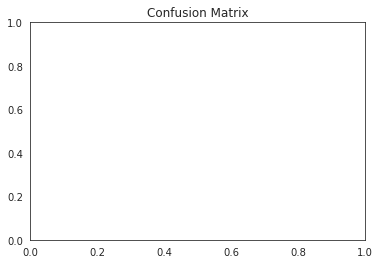

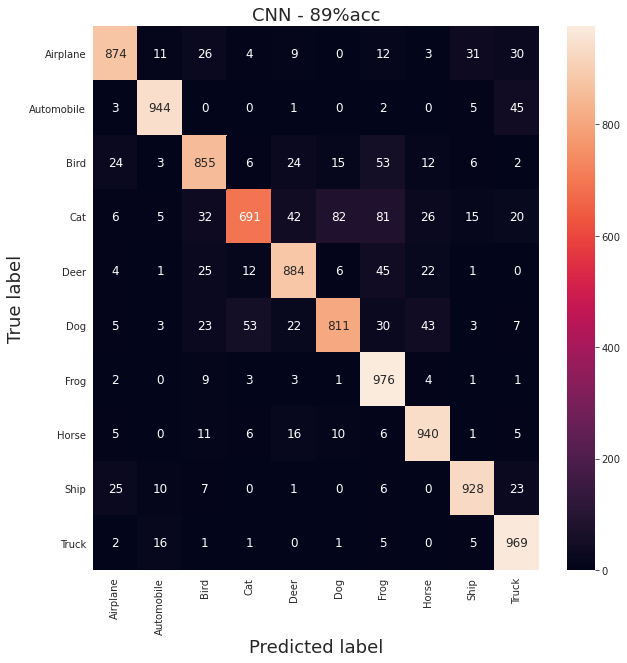

In [15]:
labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
plt.title('Confusion Matrix')
plt.figure(figsize=(10,10))
cm_df = pd.DataFrame(cm,
                     index = labels, 
                     columns = labels)
sns.heatmap(cm_df, annot=True, annot_kws={"size": 12},fmt='g')
plt.title('CNN - 89%acc',fontsize=18)
plt.ylabel('True label',fontsize=18)
plt.xlabel('Predicted label',fontsize=18)
plt.show()
#g = sns.heatmap(cm, annot=True,annot_kws={"size": 12},fmt='g')

As can be seen, specially for the classes 3 (cat) and 5(dog), there are a lot of false positives. The class of Cats is very misclassified as Dog or Frog. The Deer class is mostly misclassified as 6. This shows that although a high accuracy on test set, our model have a good amount of true positives (diagonals) but it lacks accuracy on some classes.

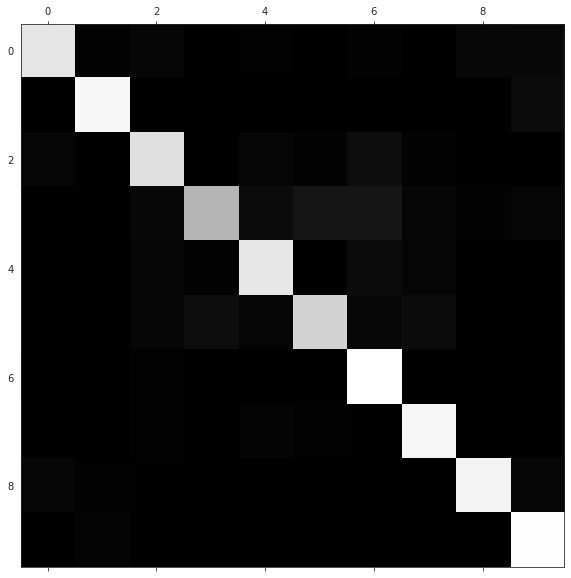

In [16]:
fig, ax = plt.subplots(figsize=(10,10))
ax.matshow(cm_df, cmap=plt.cm.gray)


From here we see that there is some pattern on the diagonal. Most squares have cleares white color, and it means the classifier predicts correctly most of the labels. The darkest ones on the diagonal reveal the bad behavior on test set fot classes 3 and 5 mostly as mentioned before. Some dark-gray squares outside the main diagonal show the classes that were misclassified. 

From these plots, we have some insights to improve our classifier. Most of the efforts should be spent on improving classification for animal labels, specially Cats, Dogs and Deers. Probably our model is good at catching basic visual patterns for theses species, but fails on detecting more specific ones. 


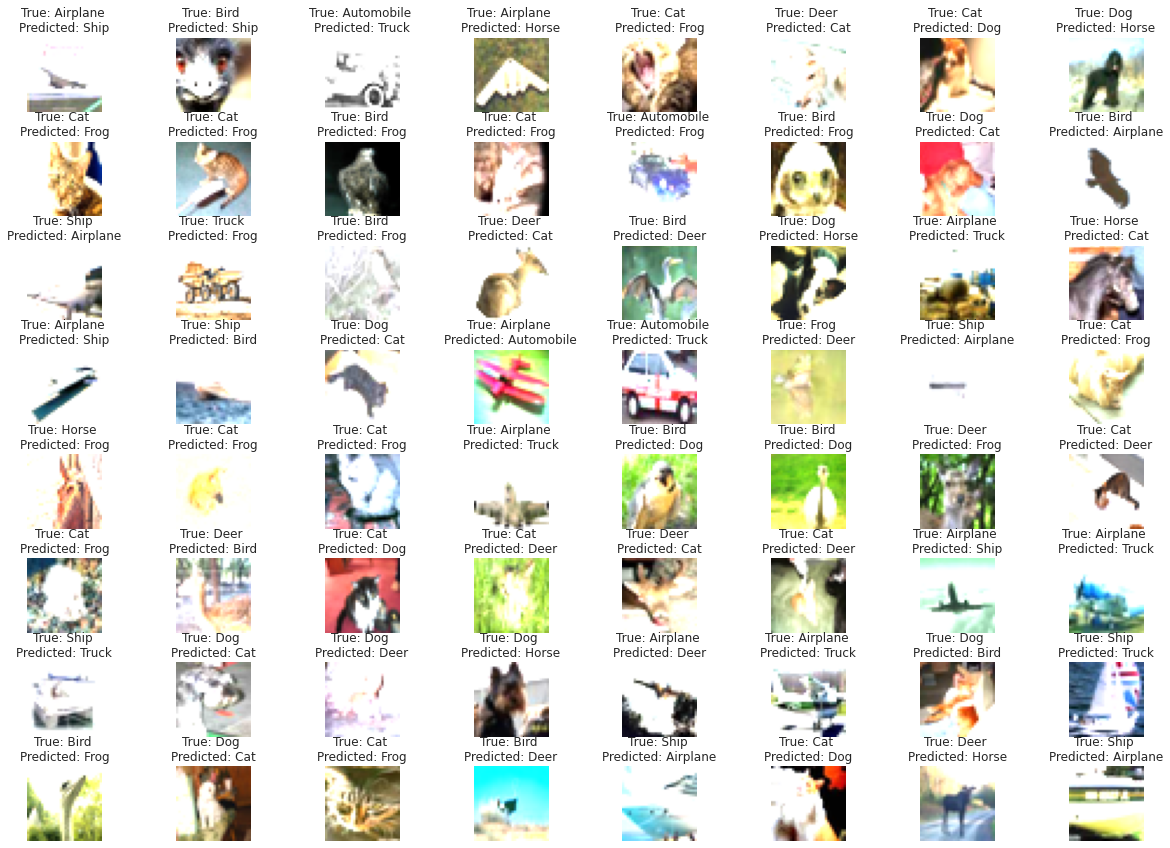

In [17]:
R = 8
C = 8
fig, axes = plt.subplots(R, C, figsize=(20,15))
axes = axes.ravel()


misclassified_idx = np.where(Y_pred_classes != Y_true)[0]
for i in np.arange(0, R*C):
    axes[i].imshow(X_validation[misclassified_idx[i]])
    axes[i].set_title("True: %s \nPredicted: %s" % (labels[Y_true[misclassified_idx[i]]], 
                                                  labels[Y_pred_classes[misclassified_idx[i]]]))
    axes[i].axis('off')
    plt.subplots_adjust(wspace=1)



Here we see some of the worst mistakes made by our model. 

# Classification Metrics 

In [18]:
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90      1000
           1       0.95      0.94      0.95      1000
           2       0.86      0.85      0.86      1000
           3       0.89      0.69      0.78      1000
           4       0.88      0.88      0.88      1000
           5       0.88      0.81      0.84      1000
           6       0.80      0.98      0.88      1000
           7       0.90      0.94      0.92      1000
           8       0.93      0.93      0.93      1000
           9       0.88      0.97      0.92      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



Comparing this with the previous model, the bigger one, we can infer some informations. Our model has a better f1-score for all of the bad performance classes in the previous report. In general it reaches a higher recall and precision for the problematic classes previously mentioned. Our recall for the 3rd class is the worst of all, meaning that our model is dealing with Cats too much as false negatives in comparison to the true positives. The 5th class has a slightly better performance on recall, but also lacks in correctly predicting true positives correctly.

# Save Best Model

In [19]:
final_testing = model.to_json()
with open("final_testing.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("final_testing.h5")
from IPython.display import FileLink, FileLinks
FileLinks('.') #lists all downloadable files on server

NameError: name 'model' is not defined

In [20]:
from IPython.display import FileLink, FileLinks
FileLinks('.') 

./
  __notebook__.ipynb

# Conclusions



We can conclude that the main objective previously outlied at the begining was reached. We have a model ~90% of accuracy on the validation set, that doesn't overfit much. All the techniques applied seemed to be useful to solve the initial overfitting problem. However, for further enhancements, we list:

#### 1. Overfitting was adressed, but underfitting came out. Our model seems to be stuck on 90% on both training and validation sets. Analyzing the model, we suppose that it is sufficiently complex to solve the problem. Nevertheless, we applied agressive dropout rates at the main convolution layers, this is, the layers with more neurons. Reading some approaches, in the original paper that introduced the dropout layers, by Hinton (2012), a dropout layer, with k-prop=0.5, is used at the end of the Dense layer. It was not applied on convolutional layers. A more recent research, by Park (2017), points that it is useful for the network combining other regularization techniques with dropouts after convolutional layers, obtaining aproximately 8% of error on the validation set. For further improvements, we plan to test more variations of the network, with lower dropout rates at hidden units and other tests following Hinton (2012) approach to compare them. 

#### 2. In most of the cases, it seems that the model shows a trending of improvement. If they could be tested for more epochs until convergence, using early stoppings as the main regularizer, there might be advantages for the model accuracy on unseen data. 

#### 3. The long time taken to converge might be related to few hyperparameter tunning. Since we found Nadam as the best choice to solve the problem, we could experimentally find an optimal learning rate by doing more experiments. We also could fine-tune the weight decay regularization. We just used one type of the possible kernel regularizers, and we set it with the default value, so it might be non optimal for our problem.

#### 4. By analyzing our confusion matrix we see that we need to improve classification of the 3rd and 5th classes. We plan to analyze better these classes on the dataset and maybe engineer some features to help the classifier identify more patterns on these classes. Apllying more advanced preprocessing techniques could also help the training, such as making some patterns stand out more.

#### 5. The main objective here was developing a neural network from scratch. It means that it would probably be not really optimized. For a better model, transfer learning could also be applied. There are many architectures consolidated for solving computer vision problem, such as VGG16, Resnet, etc, with way more complex chained layers. Since the first layers capture generic patterns from images, we could train just the final layers and get a more accurate network.

#### 6. For aditional implementation, we also recommend other techniques for scaling the image, such as pixel scaling. For hyperparameter tunning, we plan to use GridSearchCV from sklearn to automate some parameter comparison and find the most promising model to begin the experiments. 

Moreover, the model seems to solve the problem pretty well for a build from scratch approach.

# References
### [1] Aurélien Géron - Hands-on Machine Learning with Scikit-Learn and TensorFlow (2017, O’Reilly) 
### [2] http://deeplearningbook.com.br/ 
### [3] https://blog.exsilio.com/all/accuracy-precision-recall-f1-score-interpretation-of-performance- 
### [4] https://www.deeplearning.ai/tensorflow-in-practice/ <br>
### [5] https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/<br>
### [6] https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/<br>
### [7] https://medium.com/@thevatsalsaglani/multi-class-image-classification-using-cnn-over-pytorch-and-the-basics-of-cnn-fdf425a11dc0 <br> 
### [8] https://stats.stackexchange.com/questions/173663/increasing-number-of-neurons-in-convolutional-net <br> 
### [9] https://www.kaggle.com/roblexnana/cifar10-with-cnn-for-beginer <br>
### [10] https://www.quora.com/Why-would-one-use-larger-strides-in-convolutional-NNs-as-opposed-to-smaller-strides <br>

